In [1]:
import os
from scipy.misc import imread, imresize
import time
import random
import csv
import scipy.io as spio
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.rnn as rnn

%matplotlib inline
print("import 완료")
print ("TF VERSION %s" % (tf.__version__))

import 완료
TF VERSION 1.2.1


In [2]:
tf.set_random_seed(180512)  

cwd = os.getcwd() # get current path

path = '/data/rotate,shift'

file_names = ['/train_input', '/train_output', '/test_input', '/test_output']
data_name = ['train_input', 'train_output', 'test_input', 'test_output']

data_type = 0
train_input = spio.loadmat(cwd + path + file_names[data_type])
train_input = np.array(train_input[data_name[data_type]], dtype = np.float32)

data_type = 1
train_output = spio.loadmat(cwd + path + file_names[data_type])
train_output = np.array(train_output[data_name[data_type]], dtype = np.float32)

data_type = 2
test_input = spio.loadmat(cwd + path + file_names[data_type])
test_input = np.array(test_input[data_name[data_type]], dtype = np.float32)

data_type = 3
test_output = spio.loadmat(cwd + path + file_names[data_type])
test_output = np.array(test_output[data_name[data_type]], dtype = np.float32)

In [3]:
np.random.seed(201805012)
np.random.shuffle(train_input)

np.random.seed(201805012)
np.random.shuffle(train_output)

# Network Settings

In [4]:
# network options
learning_rate = 0.0001
batch_size = 5
training_epochs = 10

n_input = 784
n_step = 15
n_hidden = 1024# lstm's output
cell_num = 1


condition_num = 1 # 1 is conditional decoder which recives the last generated output as input
reverse = 1 # 1 is Last in - First out

X = tf.placeholder(tf.float32, [None, n_step, n_input])

In [5]:
def lstm_cell():
    cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, activation = tf.nn.softsign)
    return cell

with tf.variable_scope('encoder'):
    enc_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(cell_num)], state_is_tuple=True)
    enc_outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, X, dtype=tf.float32, scope ='encoder_part')
    
with tf.variable_scope('decoder'):
    dec_cell= tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(cell_num)], state_is_tuple=True)
    
    if condition_num == 0:
        print('Train using zero input')
        dec_zero = tf.zeros(tf.shape(X), dtype = tf.float32)
        dec_outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_zero,initial_state = enc_states, dtype=tf.float32, scope ='decoder_part')
        
        if reverse == 1:
            dec_outputs = tf.reverse(dec_outputs, axis=[1])
         
            dec_outputs = tf.layers.dense(inputs = dec_outputs, units = n_input, activation = None) # (batch_size, n_step, n_input)
        
    else:
        print('Train using previous output as input')

        dec_states = enc_states
        dec_inputs = tf.zeros([tf.shape(X)[0],n_input], dtype = tf.float32) # firtst input in decoder is zero

        dec_outputs = []
        
        for i in range(n_step):
            _dec_inputs, dec_states = dec_cell(dec_inputs, dec_states)
            
      
            dec_inputs = tf.layers.dense(inputs =  _dec_inputs, units = n_input, activation = None) 
            dec_outputs.append(dec_inputs)
        dec_outputs = tf.transpose(dec_outputs, [1, 0, 2])
       
    dec_outputs = tf.reverse(dec_outputs, axis=[1])

Train using previous output as input


In [6]:
cost = tf.reduce_mean(tf.pow(X  - dec_outputs,2))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

In [7]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Train

In [8]:
start_time = time.time()
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch =  len(train_input)
    for i in range(int(total_batch/batch_size)):

        batch_xs = train_input[i*batch_size:(i+1)*batch_size]
        batch_xs = np.reshape(batch_xs, [batch_size, n_step, n_input])
     
        feed_dict = {X: batch_xs}

        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
    print('\rEpoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), end = '')

end_time = time.time()
print('\n{}s'.format(end_time - start_time))

Epoch: 0010 cost = 0.004434137
309.8580000400543s


# Show the result

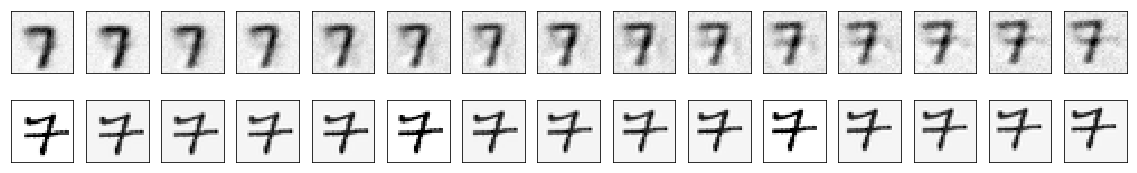

In [9]:
figure_num = 50
feed_dict = {X: train_input}
results = sess.run(dec_outputs, feed_dict = feed_dict)

fig1= plt.figure(figsize=(20,3))
for i in range(15):
    
    snap = fig1.add_subplot(2, 15, i+1)
    plt.imshow(results[figure_num,i].reshape([28, 28]), cmap = 'Greys')
    snap.set_xticks([])
    snap.set_yticks([])

    
    snap = fig1.add_subplot(2, 15, i+16)
    plt.imshow(train_input[figure_num,i].reshape([28, 28]), cmap = 'Greys')
    
    snap.set_xticks([])
    snap.set_yticks([])
plt.show()

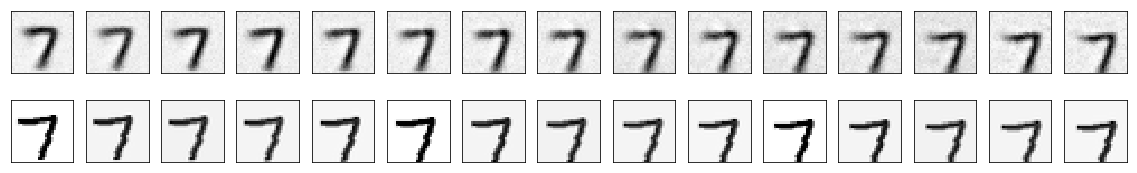

In [10]:
feed_dict = {X: test_input}
results = sess.run(dec_outputs, feed_dict = feed_dict)


fig2= plt.figure(figsize=(20,3))
for i in range(15):
    
    snap = fig2.add_subplot(2, 15, i+1)
    plt.imshow(results[figure_num,i].reshape([28, 28]), cmap = 'Greys')
    snap.set_xticks([])
    snap.set_yticks([])
        
    snap = fig2.add_subplot(2, 15, i+16)
    plt.imshow(test_input[figure_num,i].reshape([28, 28]), cmap = 'Greys')
    
    snap.set_xticks([])
    snap.set_yticks([])
plt.show()